In [1]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
mammo_o, mammo_f, label = [], [], []
data_folder = "C:/Users/anapascual/exam_project/dataset/"
os.chdir(data_folder)
l = os.listdir()

In [4]:
def create_dataset(lista, o_img, f_img, labels):
    """Function calling the Matlab file in order to filter the images.
    
    Arguments
    ---------
    
    lista : list
        Chunk of file directories.
    
    Return:
        Dataset with all the images filtered.
    """
    
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [5]:
os.chdir("C:/Users/anapascual/exam_project/")
threads = []
chunk = 6

for i in range(49):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [6]:
eng.quit()

In [7]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)

In [8]:
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))

In [9]:
def cnn_o(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(7, (4,4), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(8, (4,4), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(10, (4,4), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.1),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [10]:
model_o = cnn_o()
model_o.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 7)       119       
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 7)      28        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 7)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 7)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 8)         904       
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 8)        3

In [11]:
learning_rate = 0.001
model_o.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [13]:
X_train_o, X_val_o, Y_train_o, Y_val_o = train_test_split(mammo_o_4d, label, test_size = 0.2, random_state = 44)
batch_size = 21
traino = model_o.fit(X_train_o, Y_train_o, 
                     batch_size = batch_size,
                     epochs = 200, 
                     verbose=1,
                     validation_data=(X_val_o, Y_val_o),
                     callbacks = [reduce_on_plateau])    

Epoch 1/200
6/6 [==============================] - 2s 204ms/step - loss: 0.6852 - accuracy: 0.6239 - val_loss: 0.6909 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 102ms/step - loss: 0.5732 - accuracy: 0.7179 - val_loss: 0.6893 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 117ms/step - loss: 0.5082 - accuracy: 0.7863 - val_loss: 0.6878 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 108ms/step - loss: 0.4752 - accuracy: 0.7692 - val_loss: 0.6854 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 108ms/step - loss: 0.4856 - accuracy: 0.7521 - val_loss: 0.6824 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 127ms/step - loss: 0.4492 - accuracy: 0.7949 - val_loss: 0.6799 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 116ms/step - loss: 0.4

6/6 [==============================] - 1s 93ms/step - loss: 0.1426 - accuracy: 0.9744 - val_loss: 0.6949 - val_accuracy: 0.5333 - lr: 1.0000e-05
Epoch 54/200
6/6 [==============================] - 1s 93ms/step - loss: 0.1511 - accuracy: 0.9487 - val_loss: 0.6985 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 55/200
6/6 [==============================] - 1s 92ms/step - loss: 0.1564 - accuracy: 0.9573 - val_loss: 0.7021 - val_accuracy: 0.5333 - lr: 1.0000e-05
Epoch 56/200
6/6 [==============================] - 1s 96ms/step - loss: 0.1479 - accuracy: 0.9487 - val_loss: 0.7051 - val_accuracy: 0.5333 - lr: 1.0000e-05
Epoch 57/200
6/6 [==============================] - 1s 96ms/step - loss: 0.1580 - accuracy: 0.9573 - val_loss: 0.7080 - val_accuracy: 0.5333 - lr: 1.0000e-06
Epoch 58/200
6/6 [==============================] - 1s 95ms/step - loss: 0.1465 - accuracy: 0.9487 - val_loss: 0.7112 - val_accuracy: 0.5333 - lr: 1.0000e-06
Epoch 59/200
6/6 [==============================] - 1s 95ms/step 

Epoch 105/200
6/6 [==============================] - 1s 102ms/step - loss: 0.1552 - accuracy: 0.9573 - val_loss: 0.9147 - val_accuracy: 0.5333 - lr: 1.0000e-10
Epoch 106/200
6/6 [==============================] - 1s 124ms/step - loss: 0.1491 - accuracy: 0.9487 - val_loss: 0.9197 - val_accuracy: 0.5333 - lr: 1.0000e-10
Epoch 107/200
6/6 [==============================] - 1s 114ms/step - loss: 0.1436 - accuracy: 0.9573 - val_loss: 0.9245 - val_accuracy: 0.5333 - lr: 1.0000e-11
Epoch 108/200
6/6 [==============================] - 1s 113ms/step - loss: 0.1509 - accuracy: 0.9487 - val_loss: 0.9285 - val_accuracy: 0.5333 - lr: 1.0000e-11
Epoch 109/200
6/6 [==============================] - 1s 110ms/step - loss: 0.1520 - accuracy: 0.9573 - val_loss: 0.9323 - val_accuracy: 0.5333 - lr: 1.0000e-11
Epoch 110/200
6/6 [==============================] - 1s 98ms/step - loss: 0.1578 - accuracy: 0.9573 - val_loss: 0.9366 - val_accuracy: 0.5667 - lr: 1.0000e-11
Epoch 111/200
6/6 [======================

6/6 [==============================] - 1s 124ms/step - loss: 0.1418 - accuracy: 0.9658 - val_loss: 1.0142 - val_accuracy: 0.5667 - lr: 1.0000e-15
Epoch 157/200
6/6 [==============================] - 1s 111ms/step - loss: 0.1525 - accuracy: 0.9744 - val_loss: 1.0138 - val_accuracy: 0.5667 - lr: 1.0000e-16
Epoch 158/200
6/6 [==============================] - 1s 172ms/step - loss: 0.1479 - accuracy: 0.9658 - val_loss: 1.0141 - val_accuracy: 0.5667 - lr: 1.0000e-16
Epoch 159/200
6/6 [==============================] - 1s 124ms/step - loss: 0.1541 - accuracy: 0.9487 - val_loss: 1.0144 - val_accuracy: 0.5667 - lr: 1.0000e-16
Epoch 160/200
6/6 [==============================] - 1s 142ms/step - loss: 0.1517 - accuracy: 0.9487 - val_loss: 1.0144 - val_accuracy: 0.5667 - lr: 1.0000e-16
Epoch 161/200
6/6 [==============================] - 1s 141ms/step - loss: 0.1562 - accuracy: 0.9573 - val_loss: 1.0145 - val_accuracy: 0.5667 - lr: 1.0000e-16
Epoch 162/200
6/6 [==============================] - 1

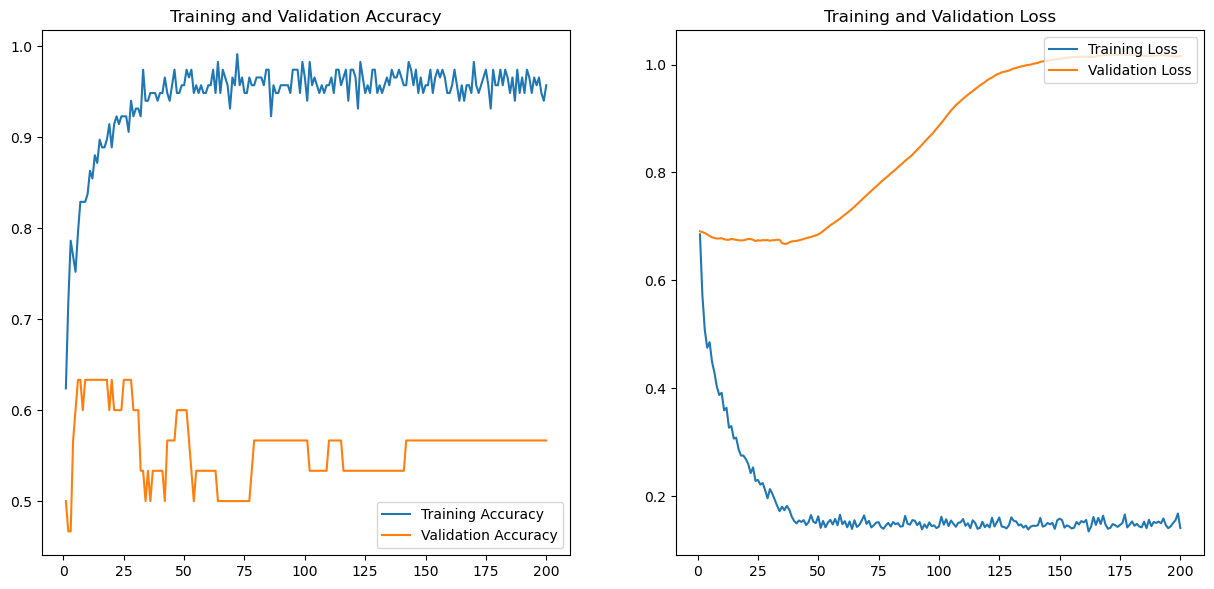

In [14]:
acc = traino.history['accuracy']
val_acc = traino.history['val_accuracy']
loss = traino.history['loss']
val_loss = traino.history['val_loss']

epochs_range = range(1, len(acc)+1)

#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation accuracy: 0.567
1/1 [==============================] - 0s 223ms/step


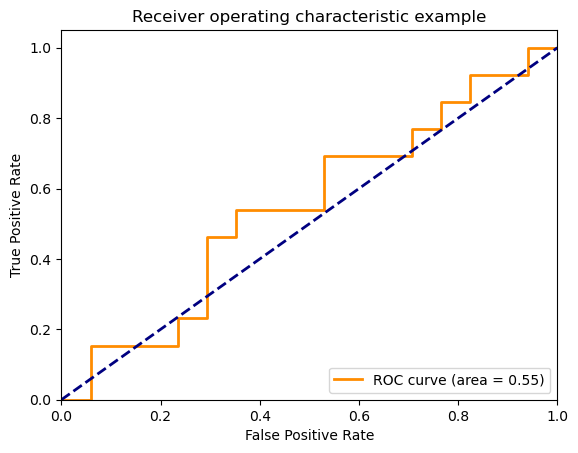

In [15]:
_, val_acc = model_o.evaluate(X_val_o, Y_val_o, verbose=0)
print('Validation accuracy: %.3f' % (val_acc))

preds = model_o.predict(X_val_o, verbose=1)

#Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(Y_val_o, preds)
roc_auc = auc(fpr, tpr)

#Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()